# Introduction

## Objectives

## Imports

In [1]:
# Basics
import numpy as np
import pandas as pd
import logging
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Machine Learning tools
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

# Extras
from pdpbox import pdp

## Logging

We are going to define here logging utilities, this is useful for debuggin and for controlling how our code is working through executions:
* **Logging file**: save important logs in logging.log file, this is useful for getting info about what our code is doing.
* **Logging stream**: print logs in real time, this is useful for tracking times and debugging our code. *Change DEBUG to INFO to decrease verbosity*.

In [2]:
# Create the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Set the format
formatter_file = logging.Formatter('%(asctime)s %(name)s %(lineno)d:%(levelname)s %(message)s')
formatter_stream = logging.Formatter('%(asctime)s : %(levelname)s %(message)s')

# Create a handler for saving the logs
file_handler = logging.FileHandler('logging.log', mode = 'w')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter_file)

# Create a handler for showing the logs
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
stream_handler.setFormatter(formatter_stream)

# Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(stream_handler)

## Environment variables

## Generic functions

In [3]:
def plot_distributions(data, n_cols = 5):
    '''
    Plot the distribution of features in a dataset.
    
    Args:
        data: pd.DataFrame, dataframe containting the data
        n_cols: integer, number of cols of the plot
    '''
    # Define the layout of the plot
    n_rows = len(data.columns.tolist()) // n_cols + 1

    plt.figure(figsize = (20, 5*n_rows))
    for i,var in enumerate(data.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot feature distribution if numeric
        if data[var].dtype in ['int64','float64']:
            sns.distplot(data[var], kde = False)
            plt.title(var + ' distribution')
            
        # Plot feature distribution if cateogorical
        elif data[var].dtype == 'category':
            sns.countplot(data[var])
            plt.title(var + ' distribution')
            plt.xticks(rotation = 45)
            
        # Skip feature otherwise
        else:
            pass
        
    plt.tight_layout()

In [4]:
def plot_vars_vs_target(data, var_target = 'Target', n_cols = 5):
    '''
    Plot the scatterplot of features vs. target in a dataset.
    
    Args:
        data: pd.DataFrame, dataframe containting the data
        var_target: string, name of the target variable
        n_cols: integer, number of cols of the plot
    '''
    # Define the layout of the plot
    n_rows = len(data.columns.tolist()) // n_cols + 1

    plt.figure(figsize = (20, 5*n_rows))
    for i,var in enumerate(data.columns):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Plot feature distribution if numeric
        if data[var].dtype in ['int64','float64']:
            sns.scatterplot(x = var, y = var_target, data = data)
            plt.title('{} vs. {}'.format(var_target, var))
            plt.xlabel(var)
            plt.ylabel(var_target)
            
        # Plot feature distribution if cateogorical
        elif data[var].dtype == 'category':
            sns.barplot(x = var, y = var_target, order = dict_labels[var].values(), data = data)
            plt.title('{} vs. {}'.format(var_target, var))
            plt.xlabel(var)
            plt.ylabel(var_target)
            plt.xticks(rotation = 45)
            
        # Skip feature otherwise
        else:
            pass
        
    plt.tight_layout()

## References

https://github.com/SauceCat/PDPbox  
https://github.com/AustinRochford/PyCEbox  
https://github.com/blent-ai/ALEPython  

# Data

We are going to use **Bike Sharing Dataset** to ilustrate the different methods we have studied. This dataset contains the daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system in Washington DC with the corresponding weather and seasonal information. We use this dataset because it contains both numerical and categorical features, so we can consider all prosible cases of features. The results we can obtain from this regression problem are easily extrapolable to a classification problem since these can be modelled as a regression to a probability funciton.

As we said, we are using the Bike Sharing Dataset (https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset),  which has the following features:
* **Index**: record index (we will not use it)
* **Date**: date (we will not use it)
* **Season**:
  * 1: Winter
  * 2: Spring
  * 3: Summer
  * 4: Fall
* **Year**: (we will not use it)
  * 0: 2011
  * 1: 2012
* **Month**: month (1 to 12)
* **Holiday**:
  * 0: Not holiday
  * 1: Holiday
* **Weekday**: day of the week (0 to 6), starting on sunday
* **WorkingDay**:
  * 0: Not holiday or weekend
  * 1: Holiday or weekend
* **Weather**:
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **Temperature**: Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39.
* **FeelingTemperature**: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50.
* **Humidity**: Normalized humidity. The values are divided to 100 (max)
* **WindSpeed**: Normalized wind speed. The values are divided to 67 (max)
* **NumCasualUsers**: count of casual users (this value is a proxi for Target, so we will not use it)
* **NumRegisteredUsers**: count of registered users (this value is a proxi for Target, so we will not use it)
* **Target**: count of total rental bikes including both casual and registered

We start by importing the data, and doing some preprocessing

In [5]:
# Import data
logger.info('Import data')
df_regression = pd.read_csv('data/bike_sharing_day.csv')

# Rename columns
df_regression.columns = ['Index',
                         'Date',
                         'Season',
                         'Year', 
                         'Month',
                         'Holiday', 
                         'Weekday', 
                         'WorkingDay',
                         'Weather',
                         'Temperature',
                         'FeelingTemperature',
                         'Humidity',
                         'WindSpeed',
                         'NumCasualUsers',
                         'NumRegisteredUsers',
                         'Target']

# Correct the types
df_regression = df_regression.astype({'Season'     : 'category',
                                      'Weather'    : 'category',
                                      })

# Process the variables
df_regression = df_regression.drop(['Index','Year','Date','NumCasualUsers','NumRegisteredUsers'], axis = 1)
df_regression['Temperature'] = df_regression['Temperature'] * (39 - (-8)) + (-8)
df_regression['FeelingTemperature'] = df_regression['FeelingTemperature'] * (50 - (-16)) + (-16)
df_regression['Humidity'] = df_regression['Humidity'] * 100
df_regression['WindSpeed'] = df_regression['WindSpeed'] * 67
df_regression['Weekday'] = (df_regression['Weekday']) + 6 % 7

# Create dictionaries with the labels of the categorical variables
dict_Season = {
    1 : 'Winter',
    2 : 'Spring',
    3 : 'Summer',
    4 : 'Fall'
    }

dict_Weather = {
    1 : 'Sunny',
    2 : 'Cloudy',
    3 : 'LightRain',
    4 : 'HeavyRain'
    }

dict_labels = {'Season'     : dict_Season,
               'Weather'    : dict_Weather
               }

for var in dict_labels.keys():
    df_regression[var] = df_regression[var].map(dict_labels[var])

2020-04-20 23:40:50,416 : INFO Import data


then take a look at the variables

In [6]:
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Season              731 non-null    category
 1   Month               731 non-null    int64   
 2   Holiday             731 non-null    int64   
 3   Weekday             731 non-null    int64   
 4   WorkingDay          731 non-null    int64   
 5   Weather             731 non-null    category
 6   Temperature         731 non-null    float64 
 7   FeelingTemperature  731 non-null    float64 
 8   Humidity            731 non-null    float64 
 9   WindSpeed           731 non-null    float64 
 10  Target              731 non-null    int64   
dtypes: category(2), float64(4), int64(5)
memory usage: 53.2 KB


and to some samples of data

In [7]:
df_regression.head()

Season  Month  Holiday  Weekday  WorkingDay Weather  Temperature  \
0  Winter      1        0       12           0  Cloudy     8.175849   
1  Winter      1        0        6           0  Cloudy     9.083466   
2  Winter      1        0        7           1   Sunny     1.229108   
3  Winter      1        0        8           1   Sunny     1.400000   
4  Winter      1        0        9           1   Sunny     2.666979   

   FeelingTemperature  Humidity  WindSpeed  Target  
0            7.999250   80.5833  10.749882     985  
1            7.346774   69.6087  16.652113     801  
2           -3.499270   43.7273  16.636703    1349  
3           -1.999948   59.0435  10.739832    1562  
4           -0.868180   43.6957  12.522300    1600

so we can plot a distribution of the variables

2020-04-20 23:40:52,618 : INFO Plot data distributions


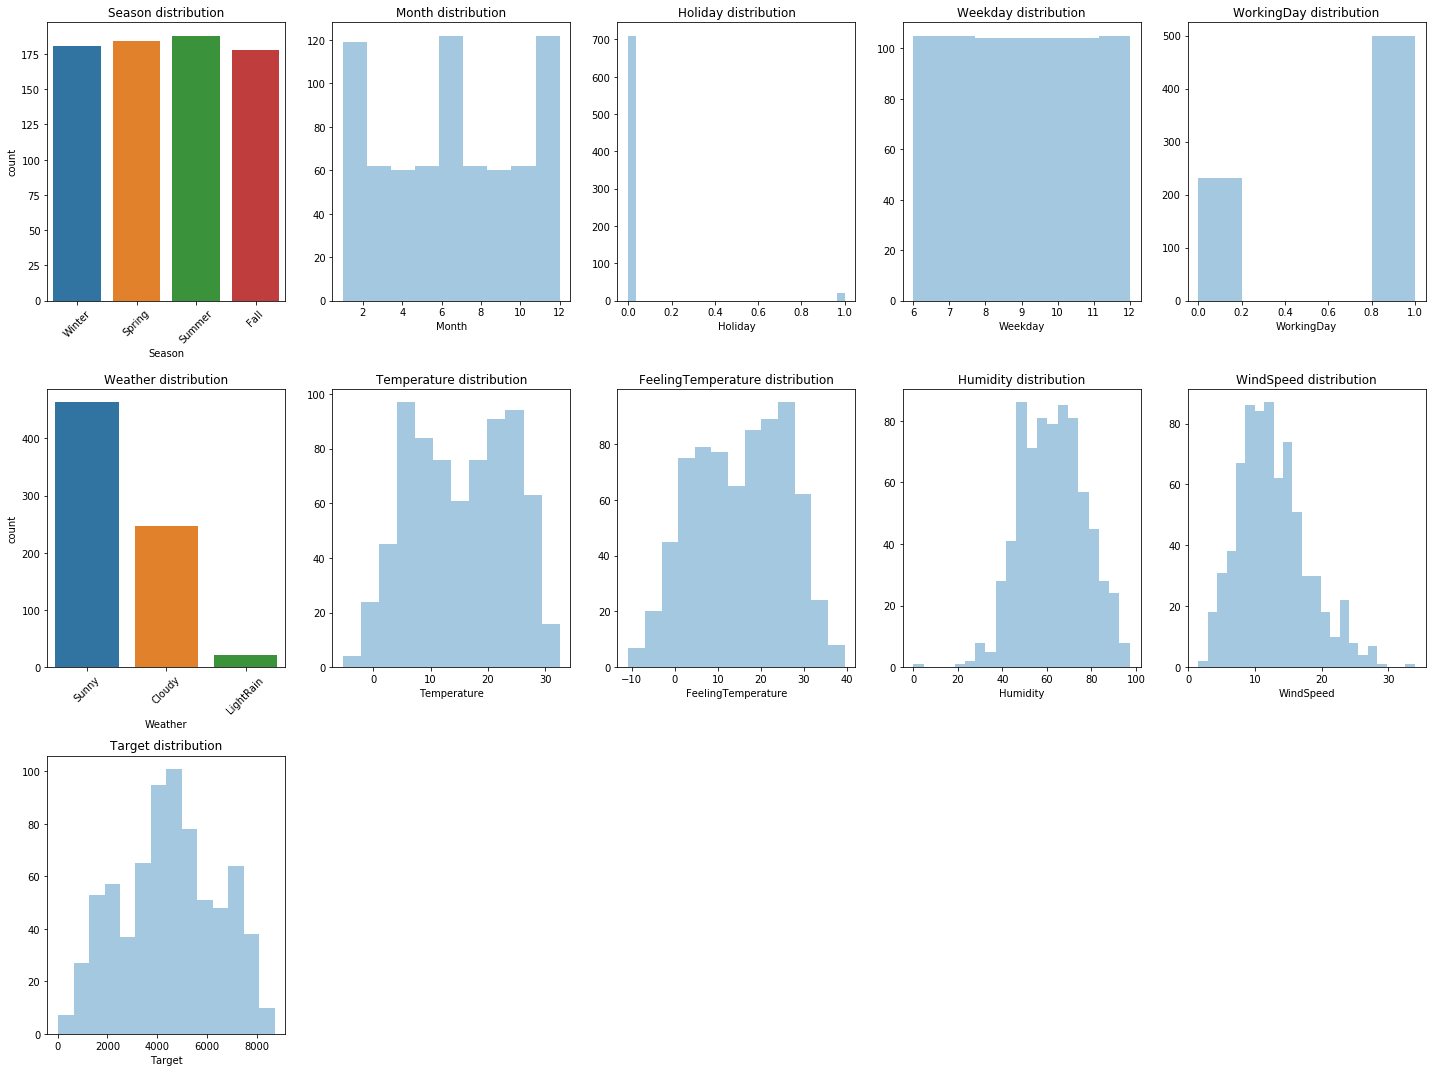

In [8]:
logger.info('Plot data distributions')
plot_distributions(df_regression)
plt.show()

and a naive plot of direct dependences

2020-04-20 23:40:55,478 : INFO Plot data targetplots


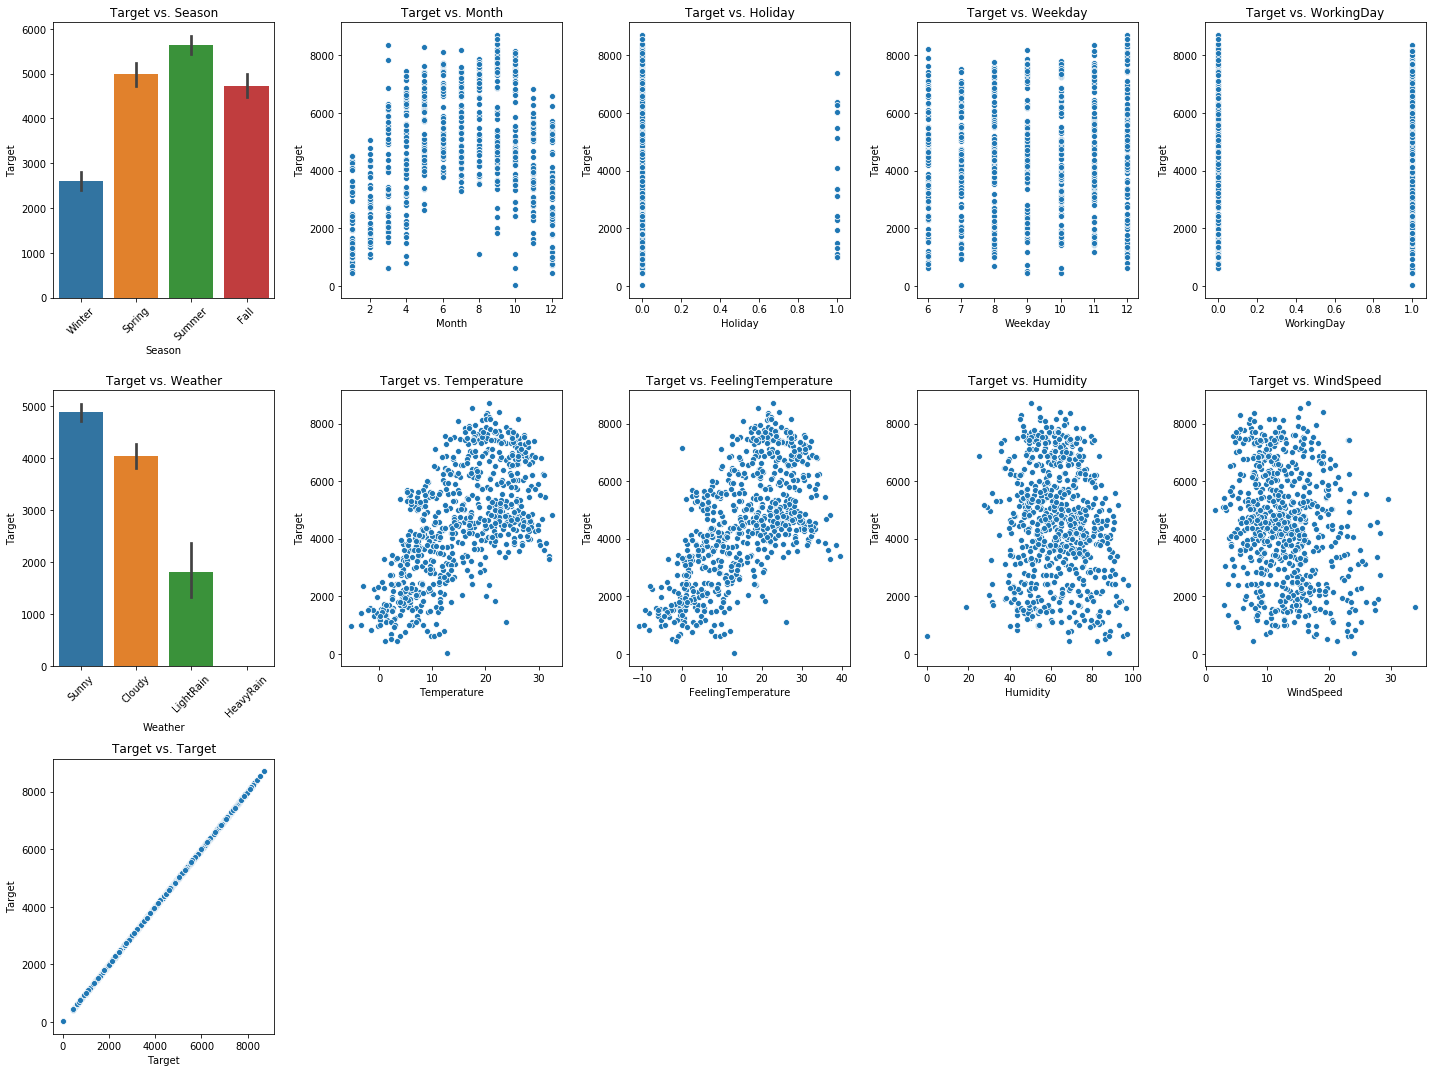

In [9]:
logger.info('Plot data targetplots')
plot_vars_vs_target(df_regression)
plt.show()

# Interpretable models

In [10]:
# Prepare the data for the model
X = df_regression.drop('Target', axis = 1).copy()
y = df_regression['Target'].copy()
    
# Save the original features
features = X.columns.tolist()
    
# Get dummies for categorical variables
if dict_labels:
    for var in dict_labels.keys():
        X_var = pd.get_dummies(X[var], prefix = var, prefix_sep = '_')
        X = X.drop(var, axis = 1)
        X = pd.concat([X, X_var], axis = 1)

# Create a train set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Linear regression

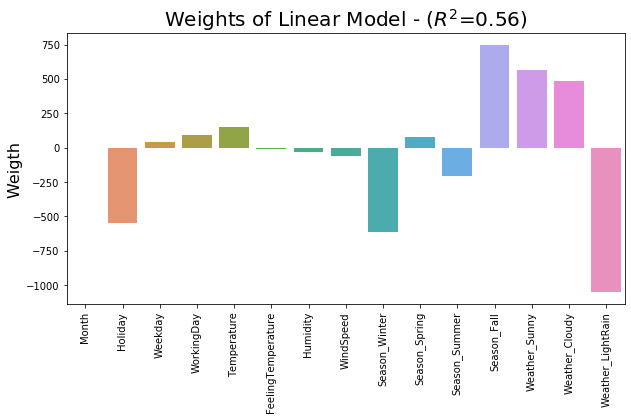

KeyError: 'horizontalalignment=1, verticalalignment=0'

In [11]:
# Initiate and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Compute weights
df_weights = pd.DataFrame({'Feature' : X.columns, 'Weight' : lr.coef_})

# Compute effects
df_effects = np.multiply(X, df_weights.iloc[:,1])

# Plot weights
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Weight', data = df_weights)
plt.title('Weights of Linear Model - ($R^2$={:.2f})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('')
plt.ylabel('Weigth', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Plot effects
plt.figure(figsize = (10, 5))
sns.boxplot(data = df_effects)
plt.title('Effects of Linear Model - ($R^2$={horizontalalignment=1, verticalalignment=0})'.format(lr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Effect', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

## Decission Tree

In [ ]:
# Initiate and train the model
dtr = DecisionTreeRegressor(max_depth = 3)
dtr.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : dtr.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot structure
plt.figure(figsize = (10, 5))
plot_tree(dtr)
plt.title('Structure of Decission Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.show()

# Plot importances
plt.figure(figsize = (10, 5))
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Decision Tree - ($R^2$={:.2f})'.format(dtr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Formatting
plt.tight_layout()
plt.show()

# Non-interpretable models

## Ranfom Forest

In [ ]:
# Initiate and train the model
rfr = RandomForestRegressor(n_estimators = 50, max_depth = 5)
rfr.fit(X_train, y_train)

# Compute importances
df_importances = pd.DataFrame({'Feature' : X.columns, 'Importance' : rfr.feature_importances_})
df_importances = df_importances.sort_values(by = 'Importance')

# Plot importances
sns.barplot(x = 'Feature', y = 'Importance', data = df_importances)
plt.title('Feature Importances of Random Forest - ($R^2$={:.2f})'.format(rfr.score(X_test, y_test)), fontsize = 20)
plt.xlabel('', fontsize = 16)
plt.ylabel('Relative Importance', fontsize = 16)
plt.xticks(rotation = 90)
plt.show()

# Model-Agnostic Methods

## Partial Dependence Plots (PDP)

As we have studied, viewing plots (PDP) of the partial dependence approximations fo the model on selected variables can help to provide a qualitative description of its properties. The algorithm to perfom these plots is the following:  
* Discretize $X_S$ for a smooth interpretation. 
* Compute the predictions of the model $f(x_S,x_C)$ por all $x_S \in X_S, x_C \in X_C$.   
* For a given $x_S \in X_S$ average the predictions over all $x_C \in X_C$.  
* Plot the averaged values vs $X_S$.

### From scratch

In [ ]:
def partial_dependence_plot(data, model, var_s, var_target = 'Target', dict_labels = None, n_grid = 10):
    '''
    Compute the partial dependence plot (PDP) of the output of a model with respect to one variable. 
    This computation is made by averaging the target variables over some selected variables, that is, 
    we select the features to keep and use as explanations, make predictions using these points, 
    and average the predictions over the unique values of the selected features.
    
    Args:
        data: pd.DataFrame, dataframe containing the training data of the model
        model: sklearn model instance, model trained with data in data
        var_s: string, name of the variable to compute the partial dependence of
        var_target: string, name of the target variable
        dict_labels: dictionary, dictionary of dictionaries with the labels of the categories for each
        categorical variable
        n_grid: integer, number of points in the PDP
    '''
    logger.info('Compute PDP for {}'.format(var_s))
    
    # Get features
    df = data.copy()
    features_with_dummies = df.columns.tolist()
    
    # Check if var_s is numeric or categorical by looking at the possible dummy variables
    numeric = True
    if var_s not in features_with_dummies:
        var_s_categories = [var for var in features_with_dummies if var_s in var]
        if len(var_s_categories) > 0:
            numeric = False
        else:
            print('This variable is not available.')
            pass
            
    # Make the grid
    logger.debug('* Making the grid')
    if numeric:
        # Discretize the variable in quantiles
        df[var_s] = [(x.left + x.right) / 2 for x in pd.qcut(df[var_s], n_grid)]

        # Get the unique values
        x_s = pd.DataFrame({var_s : df[var_s].unique(), 'key' : 0})

        # Remove the original values
        df = df.drop(var_s, axis = 1)
    else:
        # If the variable is categorical we need to get dummy version of all possible cases
        x_s = pd.DataFrame(np.identity(n = len(var_s_categories)), columns = var_s_categories)
        x_s['key'] = 0
        
        # Remove the original values
        df = df.drop(var_s_categories, axis = 1)
    
    # Make a cartesian product
    df['key'] = 0
    df = x_s.merge(df, on = 'key', how = 'left')
    df = df.drop('key', axis = 1)
    df = df[data.columns.tolist()]
        
    # Index each x_S
    df['Index'] = np.repeat(range(x_s.shape[0]), data.shape[0])
    
    # Make predictions
    logger.debug('* Making predictions')
    df['pred'] = model.predict(df.drop('Index', axis = 1).values)
    y_min = df['pred'].min()
    y_max = df['pred'].max()

    if not numeric:
        # Combine the dummy variables and recover the original categories for visualization purposes
        df_var_s = df[var_s_categories].idxmax(axis = 1)
        df_var_s = df_var_s.apply(lambda x: x.replace(var_s + '_', ''))           
        df = df.drop(var_s_categories, axis = 1)
        df[var_s] = df_var_s
    
    # Compute partial dependences
    logger.debug('* Computing partial dependences')
    df_pdp = df.groupby(var_s, as_index = False)['pred'].mean()
        
    # Make the plot
    logger.debug('* Making the plot')
    if numeric:
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     data = df_pdp
                     )
        sns.rugplot(a = data[var_s], 
                    height = 0.05, 
                    axis = 'x', 
                    alpha = 0.1
                    )
    else:
        sns.barplot(x = var_s, 
                    y = 'pred', 
                    order = dict_labels[var_s].values(), 
                    data = df_pdp
                    )
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      order = dict_labels[var_s].values(), 
                      data = df_pdp, 
                      color = 'black'
                      )
        plt.xticks(rotation = 45)
    
    # Formatting
    plt.title('PDP for {}'.format(var_s), fontsize = 20)
    plt.xlabel(var_s, fontsize = 16)
    plt.ylabel(var_target, fontsize = 16)
    plt.ylim(y_min, y_max)
        
    logger.debug('* Done')

In [ ]:
# Obtain the PDPs for variables
features = ['Temperature', 'Season']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    partial_dependence_plot(data = X_train, 
                            model = rfr, 
                            var_s = var, 
                            var_target = 'Target', 
                            dict_labels = dict_labels,
                            n_grid = 10
                            )
plt.tight_layout()
plt.show()

### Extra: PDPbox library

After developing some intuition on PDP building them from scratch, we can explore more advanced implementations of this method. A popular library for this purpose is [PDPbox](https://github.com/SauceCat/PDPbox), it provides more curated visualizations for PDPs and ICEs. We can reproduce some of our examples in its absolute

In [ ]:
# Numerical variable
pdp_Temperature = pdp.pdp_isolate(model = rfr,
                                  dataset = X_train,
                                  model_features = X_train.columns.tolist(),
                                  feature = 'Temperature'
                                  )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                         feature_name = 'Temperature', 
                         plot_lines = False, 
                         x_quantile = True, 
                         plot_pts_dist = True, 
                         show_percentile = True, 
                         center = False
                         )
plt.show()

# Categorical variable
pdp_Season = pdp.pdp_isolate(model = rfr, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = ['Season_Winter','Season_Spring','Season_Summer','Season_Fall']
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                         feature_name = 'Season', 
                         plot_lines = False,
                         plot_pts_dist = True, 
                         center = False
                         )
plt.show()

## Independent Conditional Explanation (ICE)

As we have just seen, PDPs show the mean effect of a variable in the predicitions of the model, but we can also look at how individual predictions are affected by the change of this variable. This is knonw as Individual Conditional Explanations. The idea of its calculation is very similar to PDPs:
* Discretize $X_S$ for a smooth interpretation. 
* Compute the predictions of the model $f(x_S,x_C)$ por all $x_S \in X_S, x_C \in X_C$.   
* For each given $x_C \in X_C$ plot the predicictions vs $X_S$.

### From scracth

In [ ]:
def independent_conditional_explanation(data, model, var_s, var_target = 'Target', dict_labels = None, n_grid = 10, frac_to_plot = 1.0, centered = False):
    '''
    Compute the independent conditional explanation (ICE) of the output of a model with respect to one 
    variable. This computation is made by averaging the target variables over some selected variables, that is, 
    we select the features to keep and use as explanations, make predictions using these points, 
    and average the predictions over the unique values of the selected features.
    
    Args:
        data: pd.DataFrame, dataframe containing the training data of the model
        model: sklearn model instance, model trained with data in data
        var_s: string, name of the variable to compute the partial dependence of
        var_target: string, name of the target variable
        dict_labels: dictionary, dictionary of dictionaries with the labels of the categories for each
        categorical variable
        n_grid: integer, number of points in the ICE
        frac_to_plot: float, frac of the samples to plot the ICE for
    '''
    logger.info('Compute ICE for {}'.format(var_s))
    
    # Get features
    df = data.copy()
    features_with_dummies = df.columns.tolist()
    
    # Check if var_s is numeric or categorical by looking at the possible dummy variables
    numeric = True
    if var_s not in features_with_dummies:
        var_s_categories = [var for var in features_with_dummies if var_s in var]
        if len(var_s_categories) > 0:
            numeric = False
        else:
            print('This variable is not available.')
            pass
            
    # Make the grid
    logger.debug('* Making the grid')
    if numeric:
        # Discretize the variable in quantiles
        df[var_s] = [(x.left + x.right) / 2 for x in pd.qcut(df[var_s], n_grid)]

        # Get the unique values
        x_s = pd.DataFrame({var_s : df[var_s].unique(), 'key' : 0})

        # Remove the original values
        df = df.drop(var_s, axis = 1)
    else:
        # If the variable is categorical we need to get dummy version of all possible cases
        x_s = pd.DataFrame(np.identity(n = len(var_s_categories)), columns = var_s_categories)
        x_s['key'] = 0
        
        # Remove the original values
        df = df.drop(var_s_categories, axis = 1)
    
    # Make a cartesian product
    df['key'] = 0
    df = df.merge(x_s, on = 'key', how = 'left')
    df = df.drop('key', axis = 1)
    df = df[data.columns.tolist()]
        
    # Index each x_C
    df['Index'] = np.repeat(range(data.shape[0]), x_s.shape[0])
    
    # Make predictions
    logger.debug('* Making predictions')
    df['pred'] = model.predict(df.drop('Index', axis = 1).values)
    y_min = df['pred'].min()
    y_max = df['pred'].max()

    if not numeric:
        # Combine the dummy variables and recover the original categories for visualization purposes
        df_var_s = df[var_s_categories].idxmax(axis = 1)
        df_var_s = df_var_s.apply(lambda x: x.replace(var_s + '_', ''))           
        df = df.drop(var_s_categories, axis = 1)
        df[var_s] = df_var_s
        
    # Center the plot if necessary
    if centered:
        for idx in df['Index'].unique():
            pred_min = df.loc[df['Index'] == idx, 'pred'].min()
            df.loc[df['Index'] == idx, 'pred'] = df.loc[df['Index'] == idx, 'pred'] - pred_min

    # Pepare table for plot if necessary
    if frac_to_plot < 1.:
        idx = df['Index'].max()
        idx = np.random.choice(range(idx), size = int(frac_to_plot * idx), replace = False)
        df = df[df['Index'].isin(idx)]
    
    # Compute partial dependences
    logger.debug('* Computing partial dependences')
    df_pdp = df.groupby(var_s, as_index = False)['pred'].mean()
    
    # Make the plot
    logger.debug('* Making the plot')
    if numeric:
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     hue = 'Index', 
                     data = df, 
                     alpha = 1, 
                     palette = {i : 'gray' for i in df['Index'].unique()}, 
                     legend = False
                     )
        sns.lineplot(x = var_s, 
                     y = 'pred', 
                     data = df_pdp, 
                     color = 'orange',
                     linewidth = 10
                     )
        sns.rugplot(a = data[var_s], 
                    height = 0.05, 
                    axis = 'x', 
                    alpha = 0.1, 
                    color = 'gray'
                    )
    else:
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      hue = 'Index', 
                      order = dict_labels[var_s].values(), 
                      data = df,
                      alpha = 0.1, 
                      palette = {i : 'gray' for i in df['Index'].unique()}, 
                      markers = {i : False for i in df['Index'].unique()}
                      ).legend_.remove()
        sns.pointplot(x = var_s, 
                      y = 'pred', 
                      order = dict_labels[var_s].values(), 
                      data = df_pdp,
                      color = 'orange',
                      scale = 2
                      )
        plt.xticks(rotation = 45)
        
    # Formatting
    if centered:
        plt.title('c-ICE for {}'.format(var_s), fontsize = 20)
    else:
        plt.title('ICE for {}'.format(var_s), fontsize = 20)
    plt.xlabel(var_s, fontsize = 16)
    plt.ylabel(var_target, fontsize = 16)
    plt.ylim(df['pred'].min(), df['pred'].max())

    logger.debug('* Done')

2020-04-20 23:41:04,306 : INFO Compute ICE for Temperature
2020-04-20 23:41:04,307 : DEBUG * Making the grid
2020-04-20 23:41:04,326 : DEBUG * Making predictions
2020-04-20 23:41:04,340 : DEBUG * Computing partial dependences
2020-04-20 23:41:04,345 : DEBUG * Making the plot
2020-04-20 23:41:10,790 : DEBUG * Done
2020-04-20 23:41:10,800 : INFO Compute ICE for Season
2020-04-20 23:41:10,801 : DEBUG * Making the grid
2020-04-20 23:41:10,813 : DEBUG * Making predictions
2020-04-20 23:41:10,831 : DEBUG * Computing partial dependences
2020-04-20 23:41:10,836 : DEBUG * Making the plot
2020-04-20 23:41:22,121 : DEBUG * Done


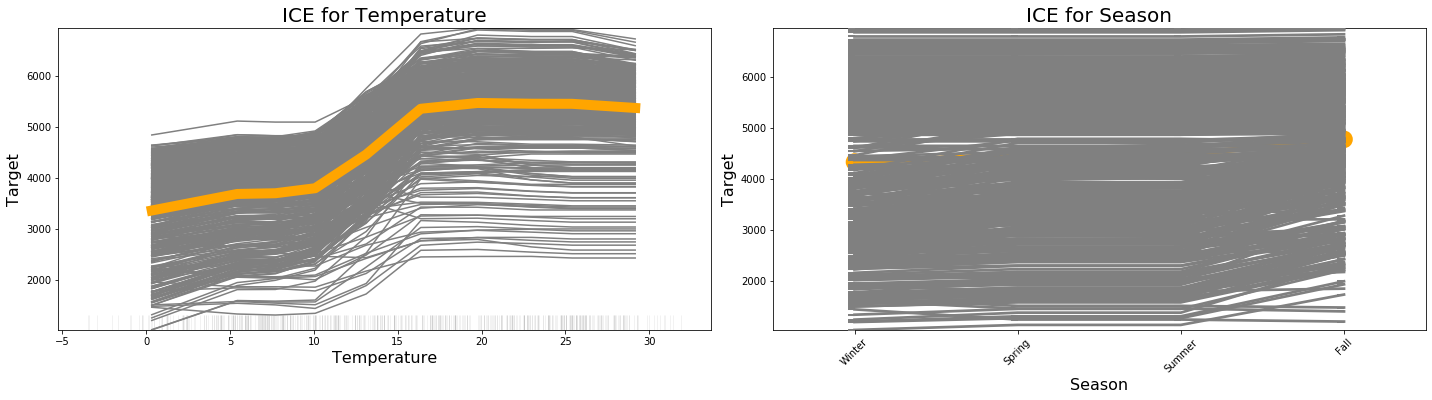

In [18]:
# Obtain the ICEs for variables
features = ['Temperature', 'Season']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    independent_conditional_explanation(data = X_train, 
                                        model = rfr, 
                                        var_s = var, 
                                        var_target = 'Target', 
                                        dict_labels = dict_labels,
                                        n_grid = 10,
                                        frac_to_plot = 1,
                                        centered = False
                                        )
plt.tight_layout()
plt.show()

2020-04-20 23:41:28,181 : INFO Compute ICE for Temperature
2020-04-20 23:41:28,182 : DEBUG * Making the grid
2020-04-20 23:41:28,194 : DEBUG * Making predictions
2020-04-20 23:41:29,534 : DEBUG * Computing partial dependences
2020-04-20 23:41:29,537 : DEBUG * Making the plot
2020-04-20 23:41:35,786 : DEBUG * Done
2020-04-20 23:41:35,795 : INFO Compute ICE for Season
2020-04-20 23:41:35,796 : DEBUG * Making the grid
2020-04-20 23:41:35,807 : DEBUG * Making predictions
2020-04-20 23:41:37,062 : DEBUG * Computing partial dependences
2020-04-20 23:41:37,065 : DEBUG * Making the plot
2020-04-20 23:41:48,533 : DEBUG * Done


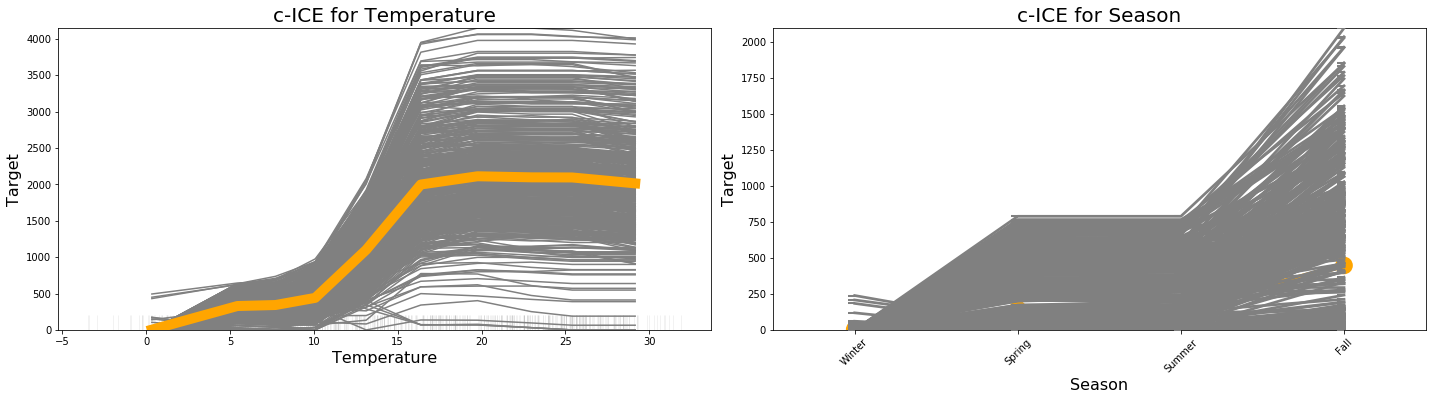

In [19]:
# Obtain the ICEs for variables
features = ['Temperature', 'Season']

# Define the layout of the plot
n_cols = 2
n_rows = len(features) // n_cols + 1

# Obtain PDP for each variable
plt.figure(figsize = (20, 5*n_rows))
for i,var in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    independent_conditional_explanation(data = X_train, 
                                        model = rfr, 
                                        var_s = var, 
                                        var_target = 'Target', 
                                        dict_labels = dict_labels,
                                        n_grid = 10,
                                        frac_to_plot = 1,
                                        centered = True
                                        )
plt.tight_layout()
plt.show()

### Extra: PDPbox library

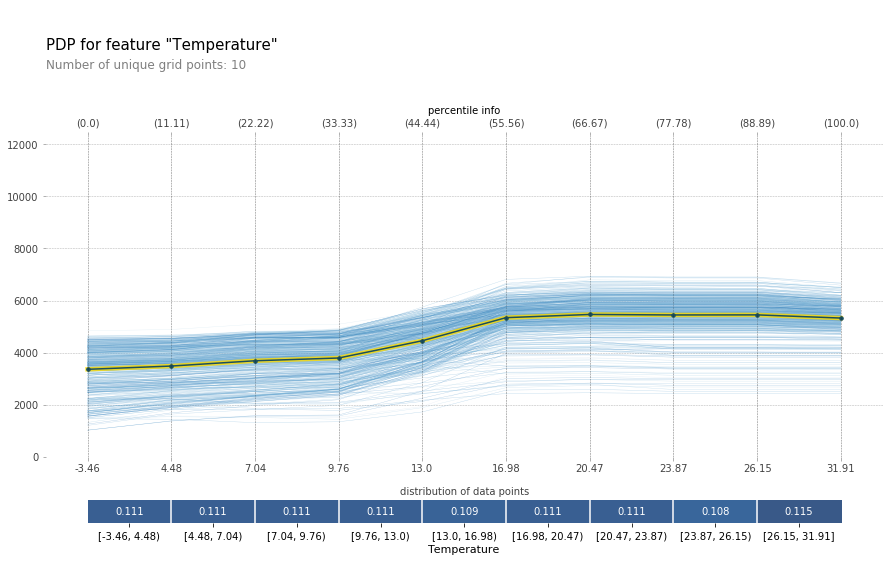

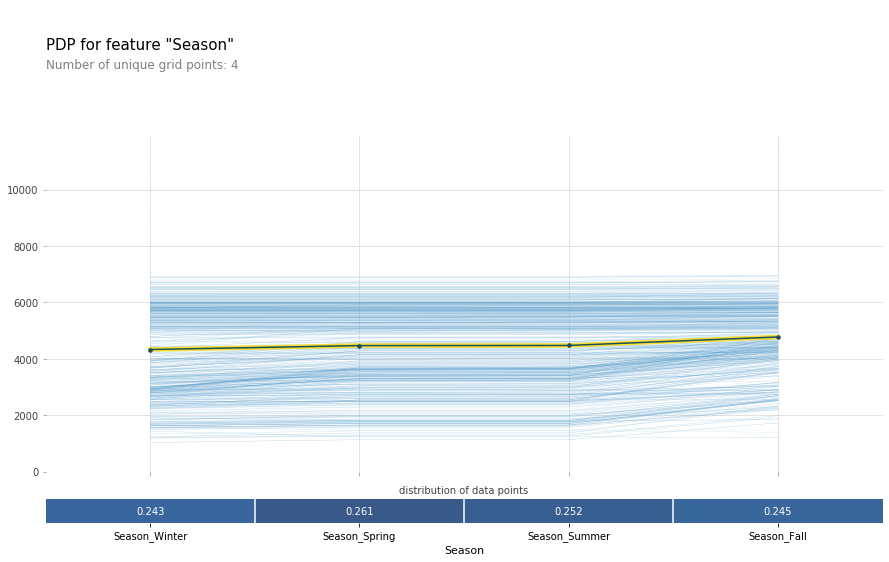

In [20]:
# Numerical variable
pdp_Temperature = pdp.pdp_isolate(model = rfr,
                                  dataset = X_train,
                                  model_features = X_train.columns.tolist(),
                                  feature = 'Temperature'
                                  )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                         feature_name = 'Temperature', 
                         plot_lines = True, 
                         x_quantile = True, 
                         plot_pts_dist = True, 
                         show_percentile = True, 
                         center = False
                         )
plt.show()

# Categorical variable
pdp_Season = pdp.pdp_isolate(model = rfr, 
                             dataset = X_train, 
                             model_features = X_train.columns.tolist(), 
                             feature = ['Season_Winter','Season_Spring','Season_Summer','Season_Fall']
                             )
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                         feature_name = 'Season', 
                         plot_lines = True,
                         plot_pts_dist = True, 
                         center = False
                         )
plt.show()

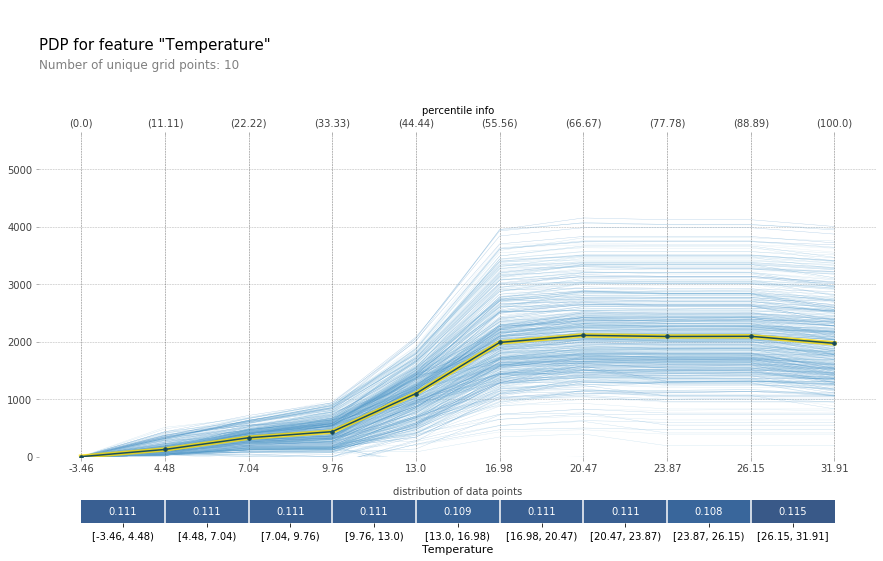

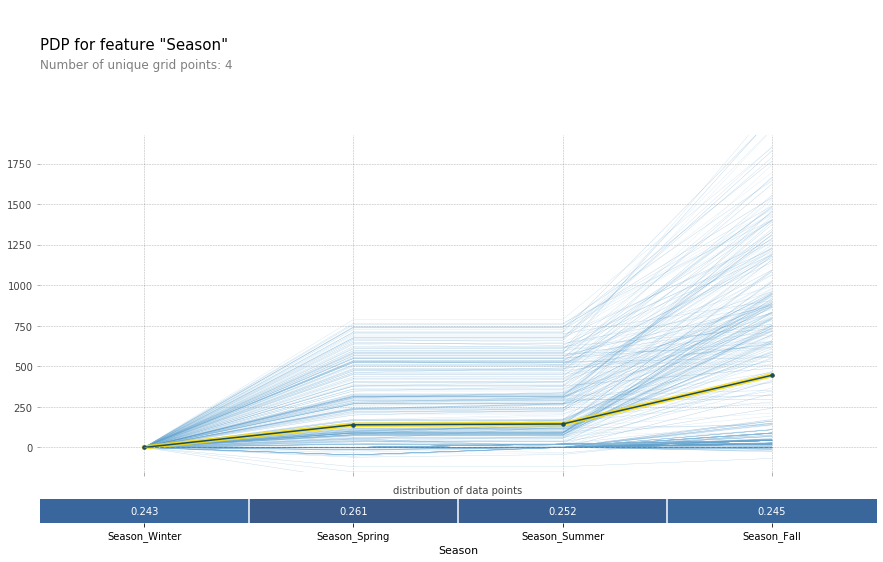

In [21]:
# Numerical variable
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Temperature, 
                                feature_name = 'Temperature', 
                                plot_lines = True, 
                                x_quantile = True, 
                                plot_pts_dist = True, 
                                show_percentile = True, 
                                center = True
                                )
plt.show()

# Categorical variable
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_Season, 
                                feature_name = 'Season', 
                                plot_lines = True,
                                plot_pts_dist = True, 
                                center = True
                                )
plt.show()

## Accumulated Local Effects (ALE)

In the process of computing PDPs and ICEs we have seen that we have to create data points following the marginal distribution of each variable, but this can lead to points that have no sense when considering the joint distribution of all variables. One way to avoid this is with A